In [2]:
import hashlib
import os
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import urllib.request
import numpy as np
import pandas as pd

In [4]:
pan_dulce_types = {'conchita': ['conchita', 'concha'],
                    'quequito': ['quequito',
                    'mantecada',
                    'mantecada de chocolate',
                    'quequito de chocolate'],
                    'puerquito': ['puerquito', 'cochinito', 'marranito', 'puerco'],
                    'elote': ['elote', 'elotito'],
                    'barquillo': ['barquillo', 'cono de crema'],
                    'orejas': ['orejas', 'orejitas'],
                    'pan-de-muerto': ['pan de muerto'],
                    'rosca-de-reyes': ['rosca de reyes'],
                    'donas': ['donas'],
                    'cuernitos': ['cuernitos', 'cuerno'],
                    'chilindrina': ['chilindrina', 'chilindrinas'],
                    'besos': ['besos', 'besitos', 'ojo de buey', 'yoyos'],
                    'niño-envuelto': ['niño envuelto']}

In [5]:
subscription_key = input('Enter your subscription key: ')
search_url = "https://api.bing.microsoft.com/v7.0/images/search"
headers = {"Ocp-Apim-Subscription-Key" : subscription_key}

In [ ]:
for pan, names in pan_dulce_types.items():
    directory = 'dataset/' + pan
    print(f'Creating {directory}')
    if not os.path.isdir(directory):
        os.makedirs(directory)
    
    queries = [name + ' pan dulce' for name in names]
    for n, query in enumerate(queries):
        nimages = 5 - len(queries)
        for i in range(nimages):
            print(f'Getting {query} images {i * 50 + 1} to {(i + 1) * 50 }')
            params  = {'q': query, 'count': 50, 'offset': i * 50}
            response = requests.get(search_url, headers=headers, params=params)
            response.raise_for_status()
            search_results = response.json()
            thumbnail_urls = [img["thumbnailUrl"] for img in search_results["value"]]
            for j, url in enumerate(thumbnail_urls):
                try:
                    urllib.request.urlretrieve(url, directory + '/' + pan + '-'+ str(j + i * 150 + n*300) + ".jpg")
                except:
                    pass

    hashes = set()
    print(f'Removing duplicates in {directory}')
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        digest = hashlib.sha1(open(path,'rb').read()).digest()
        if digest not in hashes:
            hashes.add(digest)
            os.rename(path, directory + '/' + filename)
        else:
            os.remove(path)
    print(f'Finished {directory}\n')

In [55]:
# Code to rename all images in a directory
directory = 'dataset'
df = pd.DataFrame(columns=['filename', 'label'])
# Convert labels to integers with dictionary
labels = {}

for i, folder in enumerate(os.listdir(directory)):
    labels[folder] = i
    for j, filename in enumerate(os.listdir(directory + '/' + folder)):
        #os.rename(directory + '/' + folder + '/' + filename, directory + '/' + folder + '/' + folder + '_' + str(ji) + '.jpg')
        df = pd.concat([df, pd.DataFrame({'filename': folder + '/' + folder + '_' + str(j) + '.jpg', 'label': labels[folder]}, index = [0])], axis=0)

df.to_csv('pan_dulce.csv', index=False)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import PIL
from pan_dulce_dataset import PanDulceDataset
from sklearn.model_selection import train_test_split

In [3]:
image_transforms = { 
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)), 
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5),
                                     (0.5, 0.5, 0.5))])}

train_dataset = PanDulceDataset(csv_file='pan_dulce.csv',
                            root_dir='dataset',
                            transform= image_transforms['train'])

test_dataset = PanDulceDataset(csv_file='pan_dulce.csv',
                            root_dir='dataset',
                            transform= image_transforms['test'])

classes = ('barquillo', 'besos', 'chilindrina', 'conchita', 'cuernitos',
            'donas', 'elote', 'niño-envuelto', 'orejas', 'pan-de-muerto',
            'puerquito', 'quequito', 'rosca-de-reyes')

In [4]:
num_train = len(train_dataset)
indices = list(range(num_train))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f'Train size: {len(train_dataset)}')
print(f'Test size: {len(test_dataset)}')

Train size: 1456
Test size: 364


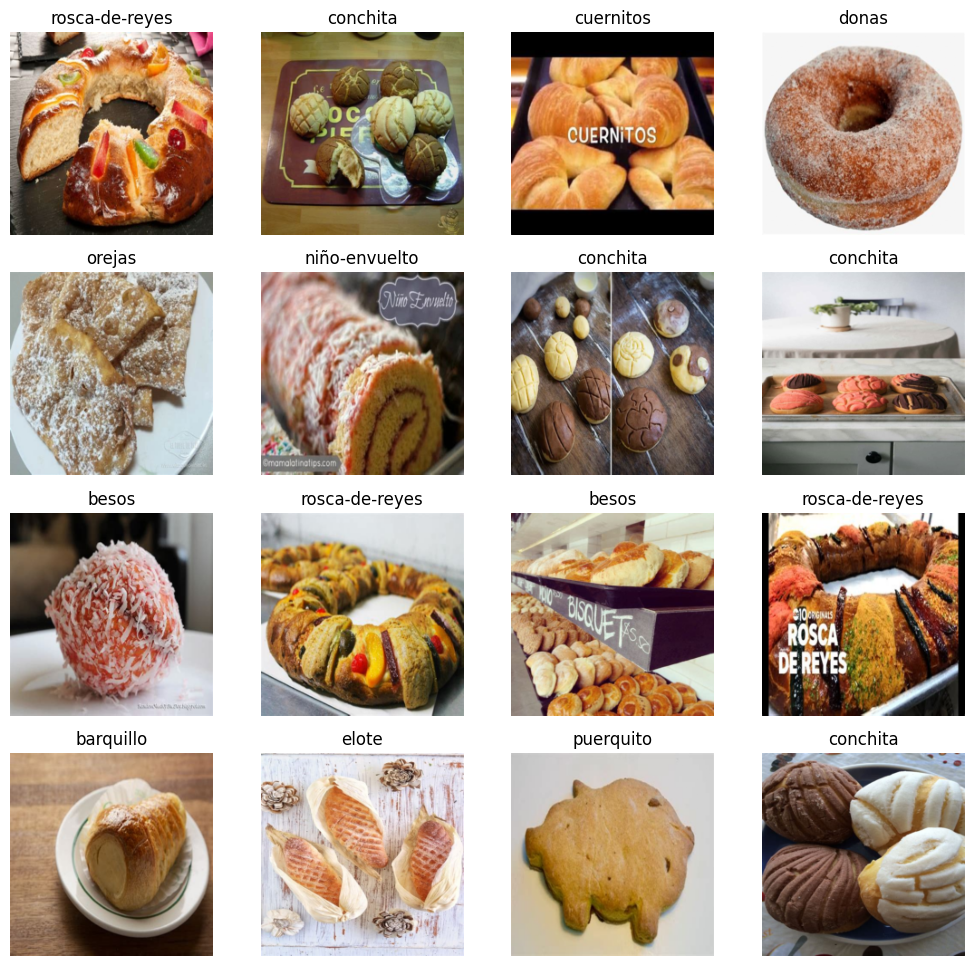

In [5]:
# view some images in training set
import matplotlib.pyplot as plt
import numpy as np

batch_X, batch_Y =  next(iter(test_loader))

plt.figure(figsize=(10,10))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i*4+j+1)
        plt.tight_layout()
        plt.imshow((batch_X[i*4+j].permute(1, 2, 0))/2 + 0.5)
        plt.title(classes[batch_Y[i*4+j]])
        plt.axis('off')
plt.show()